In [ ]:
#Dataset setup
http://vision.stanford.edu/aditya86/ImageNetDogs/main.html

#Images
http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

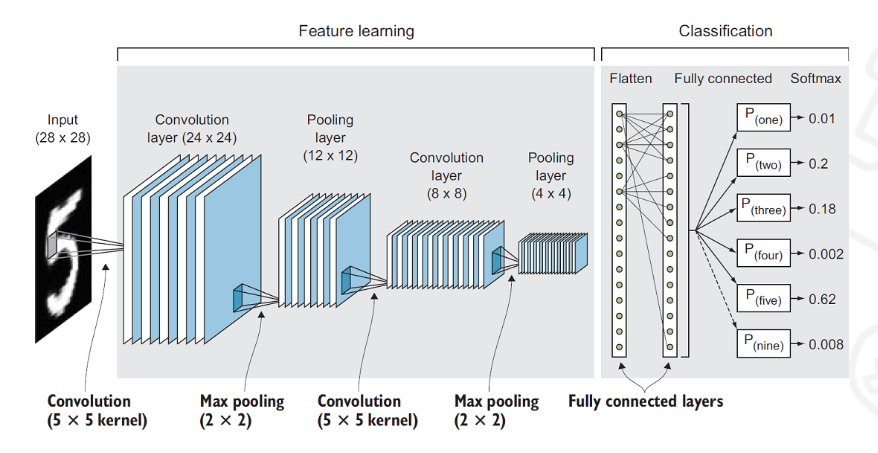

#ProjectHere

##Module dependencies

In [ ]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET
import os
import re
from google.colab import drive
import shutil
import csv
from tsai.all import *

##Fetch Database and Save Locally

In [ ]:
!curl http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar --output StanfordDogsDataset.tar
!curl http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar --output List.tar
!curl http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar --output Annotation.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  756M  100  756M    0     0  73.8M      0  0:00:10  0:00:10 --:--:-- 61.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  470k  100  470k    0     0  1966k      0 --:--:-- --:--:-- --:--:-- 1958k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20.8M  100 20.8M    0     0  10.8M      0  0:00:01  0:00:01 --:--:-- 10.8M


In [ ]:
!tar -xvf "/content/StanfordDogsDataset.tar" -C "/content/"
!tar -xvf "/content/Annotation.tar" -C "/content/"
!tar -xvf "/content/List.tar" -C "/content/"     #[run this cell to extract tar files]

A saída de streaming foi truncada nas últimas 5000 linhas.
Annotation/n02108089-boxer/n02108089_1575
Annotation/n02108089-boxer/n02108089_1619
Annotation/n02108089-boxer/n02108089_1626
Annotation/n02108089-boxer/n02108089_1654
Annotation/n02108089-boxer/n02108089_1672
Annotation/n02108089-boxer/n02108089_1675
Annotation/n02108089-boxer/n02108089_1690
Annotation/n02108089-boxer/n02108089_1748
Annotation/n02108089-boxer/n02108089_1757
Annotation/n02108089-boxer/n02108089_1775
Annotation/n02108089-boxer/n02108089_1859
Annotation/n02108089-boxer/n02108089_1912
Annotation/n02108089-boxer/n02108089_1956
Annotation/n02108089-boxer/n02108089_200
Annotation/n02108089-boxer/n02108089_2007
Annotation/n02108089-boxer/n02108089_2056
Annotation/n02108089-boxer/n02108089_2106
Annotation/n02108089-boxer/n02108089_2355
Annotation/n02108089-boxer/n02108089_2360
Annotation/n02108089-boxer/n02108089_2367
Annotation/n02108089-boxer/n02108089_2432
Annotation/n02108089-boxer/n02108089_2482
Annotation/n021080

##Database fix locally

In [ ]:
import xml.etree.ElementTree as ET
import os

def AnnotationFix(AnnoXml):
  tree = ET.parse(AnnoXml)
  root = tree.getroot()

  AnnoPath = AnnoXml.split("/")

  DirStringAnno = "/content/Annotation/"
  folder = re.split('n|-', AnnoPath[3])[1]
  filename = AnnoPath[4]
  breed = root[5][0].text

  for elem in tree.iterfind('folder'):
    elem.text = folder

  for elem in tree.iterfind('filename'):
    elem.text = filename


  "{3}n{0}-{1}/{2}".format(folder, breed, filename, DirStringAnno), #filepath
  
  tree.write("{0}".format(AnnoXml))
  return

In [ ]:
ListofAnnoFix = list()
AnnoWithIssues = ['/content/Annotation/n02108915-French_bulldog',
                  '/content/Annotation/n02105855-Shetland_sheepdog',
                  '/content/Annotation/n02089973-English_foxhound',
                  '/content/Annotation/n02091635-otterhound'
                  ]
for elem in AnnoWithIssues:
   for (dirpath, dirnames, filenames) in os.walk(elem):
    ListofAnnoFix += [os.path.join(dirpath, file) for file in filenames]
for FilePath in ListofAnnoFix:
    AnnotationFix(FilePath)

##List all local files in DB

In [ ]:
# Get the list of all files in directory tree at given path
listOfFiles = list()
for (dirpath, dirnames, filenames) in sorted(os.walk('/content/Annotation')):
    listOfFiles += [os.path.join(dirpath, file) for file in filenames]

##Image Manipulation Functions

In [ ]:
def AnnotationParse(AnnoXml):
  root = ET.parse(AnnoXml).getroot()
  DirString = "/content/Images/"
  #XML interesting data
  folder = root[0].text
  filename = root[1].text
  breed = root[5][0].text

  NewList = [
             "{3}n{0}-{1}/{2}.jpg".format(folder, breed, filename, DirString), #filepath
             folder,
             filename,
             breed,
             [root[5][4][0].text, #xmin
              root[5][4][1].text, #ymin
              root[5][4][2].text, #xmax
              root[5][4][3].text, #ymax
             ]
            ]
  return NewList

In [ ]:
def DogCrop(Img, listBoundCoords):
  #NewImg = np.copy(Img);
  xmin = int(listBoundCoords[0])
  xmax = int(listBoundCoords[2])
  ymin = int(listBoundCoords[1])
  ymax = int(listBoundCoords[3])
  NewImg = Img[ymin:ymax, xmin:xmax];
  return NewImg

In [ ]:
def ResizePhotos(Img, ImgDim):
  NewImg = cv2.resize(Img, ImgDim)
  return NewImg

In [ ]:
def SaveResizedImg(Img, ImgName, TargetDir):
  if (not os.path.isdir(TargetDir)):
    os.mkdir(TargetDir)
  filename = "{0}/{1}.jpg".format(TargetDir,ImgName)
  cv2.imwrite(filename, Img)
  return filename

##Image Preprocessing
makes all Images 224x224 cropped in the dog according to bounds

In [ ]:
itList = []
X_total = []
Y_total = []

PicSizeDim = (224,224)
TargetDir = '/content/ImagePreProc'
for it in listOfFiles:
  itDogAnnots = AnnotationParse(it)
  itList += [itDogAnnots]

  loadImg = cv2.imread(itDogAnnots[0])
  loadImg = DogCrop(loadImg, itDogAnnots[4])
  loadImg = ResizePhotos(loadImg, PicSizeDim)
  ImgResizeFilepath = SaveResizedImg(loadImg,itDogAnnots[2],TargetDir)
  
  X_total += [ImgResizeFilepath]
  Y_total += [itDogAnnots[3]]

##Load G-Drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Saves Resized Images to Drive

In [ ]:
!tar -C /content -czvf PreProcessedDogImages.tar ImagePreProc/

In [ ]:
with open('/content/DogDataset.csv', 'w', newline = '') as csvfile:
    writer = csv.writer(csvfile, delimiter = ',')
    writer.writerows(zip(X_total,Y_total))

In [ ]:
!du -sh /content/PreProcessedDogImages.tar

462M	/content/PreProcessedDogImages.tar


In [ ]:
CopySource = '/content/PreProcessedDogImages.tar'
CopyDestination = '/content/gdrive/MyDrive/PreProcessedDogImages.tar'
if not(os.path.exists(CopyDestination)):
  shutil.copy(CopySource,CopyDestination)

CopySource = '/content/DogDataset.csv'
CopyDestination = '/content/gdrive/MyDrive/DogDataset.csv'
if not(os.path.exists(CopyDestination)):
  shutil.copy(CopySource,CopyDestination)

#Load Resized Images from Drive to Session

In [ ]:
CopyDestination = '/content/PreProcessedDogImages.tar'
CopySource = '/content/gdrive/MyDrive/PreProcessedDogImages.tar'
if not(os.path.exists(CopyDestination)):
  shutil.copy(CopySource,CopyDestination)
!tar -xf '/content/PreProcessedDogImages.tar'
#!tar -xvf '/content/PreProcessedDogImages.tar'

CopyDestination = '/content/DogDataset.csv'
CopySource = '/content/gdrive/MyDrive/DogDataset.csv'
if not(os.path.exists(CopyDestination)):
  shutil.copy(CopySource,CopyDestination)


In [ ]:
import csv

with open('/content/DogDataset.csv', newline='') as f:
    reader = csv.reader(f)
    content = list(reader)

X_total = 20580*[None]
Y_total = 20580*[None]
for idx,elem in enumerate(content):
  X_total[idx] = elem[0]
  Y_total[idx] = elem[1]

##Encode the output to one-hot

In [ ]:
from sklearn import preprocessing

DogLabels = preprocessing.LabelEncoder()
DogLabels.fit(Y_total) #fit models from string to categorical
DogLabels.classes_ #return class labels
#DogLabels.transform(["Chihuahua"]) #transform the strings to nums
#DogLabels.inverse_transform([0, 0, 1, 2]) #input nums get labels back
Y_total_dogs = DogLabels.transform(Y_total) #fit models from string to categorical


In [ ]:
DogLabels.classes_

array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
       'American_Staffordshire_terrier', 'Appenzeller',
       'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
       'Blenheim_spaniel', 'Border_collie', 'Border_terrier',
       'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon',
       'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever',
       'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound',
       'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog',
       'French_bulldog', 'German_shepherd', 'German_short-haired_pointer',
       'Gordon_setter', 'Great_Dane', 'Great_Pyrenees',
       'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter',
       'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound',
       'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier',
       'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa',
       'Maltese_dog', 'Mexican_hairless', 'Newfoundland',
       

In [ ]:
from keras.utils import np_utils

num_classes = 120 #
Y_total_dogs_onehots = np_utils.to_categorical(Y_total_dogs, num_classes)

In [ ]:
Y_total_dogs_onehots.shape

(20580, 120)

##Split the dataset in Train/Test

In [ ]:
Y_idx = [x for x in range(20580)]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, Idx_train, Idx_test = train_test_split(X_total, Y_total_dogs_onehots, Y_idx, test_size=0.2 ,random_state=100,stratify=Y_total) #80%/20% test split

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

16464
4116
16464
4116


In [ ]:
Y_total_dogs_onehots.shape

(20580, 120)

In [ ]:
path = Path('/content/')
create_empty_array((len(X_train),224,224,3), fname='X_train_nparray_on_disk', path=path, mode='r+',dtype='float32')
create_empty_array((len(X_test),224,224,3), fname='X_test_nparray_on_disk', path=path, mode='r+',dtype='float32')
create_empty_array((len(Y_train),120), fname='Y_train_nparray_on_disk', path=path, mode='r+',dtype='float32')
create_empty_array((len(Y_test),120), fname='Y_test_nparray_on_disk', path=path, mode='r+',dtype='float32')

##Converting the images to numpy arrays

In [ ]:
#path = Path('/content/')
#X = create_empty_array((20580,224,224,3), fname='X_Total_nparray_on_disk', path=path, mode='r+',dtype='float32')
#del X

In [ ]:
#print(f'X array: {os.path.getsize("/content/X_Total_nparray_on_disk.npy"):12} bytes ({bytes2GB(os.path.getsize("/content/X_Total_nparray_on_disk.npy")):3.2f} GB)')

In [ ]:
X_train_on_disk = np.load('/content/X_train_nparray_on_disk.npy', mmap_mode='r+')
X_test_on_disk = np.load('/content/X_test_nparray_on_disk.npy', mmap_mode='r+')
Y_train_on_disk = np.load('/content/Y_train_nparray_on_disk.npy', mmap_mode='r+')
Y_test_on_disk = np.load('/content/Y_test_nparray_on_disk.npy', mmap_mode='r+')

In [ ]:
#print(f'X array on disk: {sys.getsizeof(X_total_on_disk):12} bytes ({bytes2GB(sys.getsizeof(X_total_on_disk)):3.3f} GB)')

X array on disk:          192 bytes (0.000 GB)


In [ ]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

for idx,ImgPath in enumerate(X_train):
  i = load_img(ImgPath)
  ImgAsArray = img_to_array(i)
  ImgAsArray = ImgAsArray/255 #normalizes for 0-1 range
  X_train_on_disk[idx] = ImgAsArray

In [ ]:
for idx,ImgPath in enumerate(X_test):
  i = load_img(ImgPath)
  ImgAsArray = img_to_array(i)
  ImgAsArray = ImgAsArray/255 #normalizes for 0-1 range
  X_test_on_disk[idx] = ImgAsArray

In [ ]:
for idx,elem in enumerate(Y_train):
  Y_train_on_disk[idx] = elem

In [ ]:
for idx,elem in enumerate(Y_test):
  Y_test_on_disk[idx] = elem

##Alternativa na memoria

In [ ]:
X_train_on_disk = [None]*20580
for idx,ImgPath in enumerate(X_train):
  i = load_img(ImgPath)
  ImgAsArray = img_to_array(i)
  ImgAsArray = ImgAsArray/255 #normalizes for 0-1 range
  X_train_on_disk[idx] = ImgAsArray

In [ ]:
X_test_on_disk = [None]*20580
for idx,ImgPath in enumerate(X_test):
  i = load_img(ImgPath)
  ImgAsArray = img_to_array(i)
  ImgAsArray = ImgAsArray/255 #normalizes for 0-1 range
  X_test_on_disk[idx] = ImgAsArray

In [ ]:
Y_train_on_disk = [None]*20580
for idx,elem in enumerate(Y_train):
  Y_train_on_disk[idx] = elem

In [ ]:
Y_test_on_disk = [None]*20580
for idx,elem in enumerate(Y_test):
  Y_test_on_disk[idx] = elem

#Save and Load Variables on Disk

##Save Variables on Disk

In [ ]:
path = Path('/content/')
create_empty_array((len(X_train),224,224,3), fname='X_train_nparray_on_disk', path=path, mode='r+',dtype='float32')
create_empty_array((len(X_test),224,224,3), fname='X_test_nparray_on_disk', path=path, mode='r+',dtype='float32')
create_empty_array((len(Y_train),120), fname='Y_train_nparray_on_disk', path=path, mode='r+',dtype='float32')
create_empty_array((len(Y_test),120), fname='Y_test_nparray_on_disk', path=path, mode='r+',dtype='float32')

In [ ]:
SourceDir = '/content/'
DestinationDir = '/content/gdrive/MyDrive/'
FilesToCopy = ['X_test_nparray_on_disk.npy',
               'X_train_nparray_on_disk.npy',
               'Y_test_nparray_on_disk.npy',
               'Y_train_nparray_on_disk.npy']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  if not(os.path.exists(CopyDestination)):
    shutil.copy(CopySource,CopyDestination)

##Load Variables from Disk

In [ ]:
DestinationDir = '/content/'
SourceDir = '/content/gdrive/MyDrive/'

FilesToCopy = ['X_test_nparray_on_disk.npy',
               'X_train_nparray_on_disk.npy',
               'Y_test_nparray_on_disk.npy',
               'Y_train_nparray_on_disk.npy']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  if not(os.path.exists(CopyDestination)):
    shutil.copy(CopySource,CopyDestination)

In [ ]:
X_train_on_disk = np.load('/content/X_train_nparray_on_disk.npy', mmap_mode='r')
X_test_on_disk = np.load('/content/X_test_nparray_on_disk.npy', mmap_mode='r')
Y_train_on_disk = np.load('/content/Y_train_nparray_on_disk.npy', mmap_mode='r')
Y_test_on_disk = np.load('/content/Y_test_nparray_on_disk.npy', mmap_mode='r')

In [ ]:
print(f'X array: {os.path.getsize("/content/X_train_nparray_on_disk.npy"):12} bytes ({bytes2GB(os.path.getsize("/content/X_train_nparray_on_disk.npy")):3.2f} GB)')

X array:   9913172096 bytes (9.23 GB)


In [ ]:
print(f'X array on disk: {sys.getsizeof(X_train_on_disk):12} bytes ({bytes2GB(sys.getsizeof(X_train_on_disk)):3.3f} GB)')

X array on disk:          192 bytes (0.000 GB)


In [ ]:
del X_train_on_disk, X_test_on_disk, Y_train_on_disk, Y_test_on_disk

#Model 1

In [ ]:
from keras.models import Sequential
from keras.layers import *

# build the model object
model = Sequential()
# CONV_1: add CONV layer with RELU activation and depth = 32 kernels
model.add(Conv2D(filters=32, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3)))
# POOL_1: downsample the image to choose the best features 
model.add(MaxPooling2D(pool_size=(2, 2)))
##112x112x96
# CONV_2: here we increase the depth to 32
model.add(Conv2D(filters=32, kernel_size=3,padding='same', activation='relu'))
# POOL_2: more downsampling
model.add(MaxPooling2D(pool_size=(2, 2)))
# CONV_3: here we increase the depth to 32
model.add(Conv2D(filters=32, kernel_size=3,padding='same', activation='relu'))
# POOL_3: more downsampling
model.add(MaxPooling2D(pool_size=(2, 2)))
##28x28x32
# flatten since too many dimensions, we only want a classification output
model.add(Flatten())
# FC_1: fully connected to get all relevant data
model.add(Dense(2000, activation='relu'))

# FC_2: fully connected to get all relevant data
model.add(Dense(2000, activation='relu'))

# FC_3: output a softmax to squash the matrix into output probabilities for the 120 classes
model.add(Dense(120, activation='softmax'))
model.summary()

##Model Compilation

In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

##Model Training

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ES = EarlyStopping(monitor="val_loss",patience=5,mode="min")

checkpointer = ModelCheckpoint(filepath='/content/model_t1.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

In [ ]:
from keras.callbacks import ModelCheckpoint   

# train the model
hist = model.fit_generator(IMGS_GEN, epochs=100, steps_per_epoch=392,
          validation_data=(X_test_on_disk, Y_test_on_disk), callbacks=[ES, checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/100
392/392 [==============================] - ETA: 0s - loss: 4.7509 - accuracy: 0.0293
Epoch 1: val_loss improved from inf to 4.18571, saving model to /content/model_t1.weights.best.hdf5
392/392 [==============================] - 45s 94ms/step - loss: 4.7509 - accuracy: 0.0293 - val_loss: 4.1857 - val_accuracy: 0.0576
Epoch 2/100
392/392 [==============================] - ETA: 0s - loss: 3.9328 - accuracy: 0.0887
Epoch 2: val_loss improved from 4.18571 to 3.83394, saving model to /content/model_t1.weights.best.hdf5
392/392 [==============================] - 21s 53ms/step - loss: 3.9328 - accuracy: 0.0887 - val_loss: 3.8339 - val_accuracy: 0.1013
Epoch 3/100
391/392 [============================>.] - ETA: 0s - loss: 3.1541 - accuracy: 0.2156
Epoch 3: val_loss did not improve from 3.83394
392/392 [==============================] - 17s 44ms/step - loss: 3.1532 - accuracy: 0.2158 - val_loss: 4.3423 - val_accuracy: 0.1113
Epoch 4/100
391/392 [============================>.] - ETA:

##Load Best Performing Model

In [ ]:
# load the weights that yielded the best validation accuracy
model.load_weights('model_t1.weights.best.hdf5')

In [ ]:
print(f'X array: {os.path.getsize("/content/model_t1.weights.best.hdf5"):12} bytes ({bytes2GB(os.path.getsize("/content/model.weights.best.hdf5")):3.2f} GB)')

X array:    435573784 bytes (0.41 GB)


##Get Best Model performance Accuracy

In [ ]:
# evaluate test accuracy
score = model.evaluate(X_test_on_disk, Y_test_on_disk, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 10.1312%


#Model 2

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6494431078237630885
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16152002560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3521421184774165403
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [
                    tf.config.experimental.VirtualDeviceConfiguration(
                        memory_limit=14288  # set your limit
                    )
                ],
            )
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [ ]:
from keras.models import Sequential
from keras.layers import *

# build the model object
model_t2 = Sequential()

#First
model_t2.add(Conv2D(filters=64, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3)))
model_t2.add(MaxPooling2D(pool_size=(2, 2)))

#Second
model_t2.add(Conv2D(filters=128, kernel_size=3,padding='same', activation='relu'))
model_t2.add(MaxPooling2D(pool_size=(2, 2)))

#Third
model_t2.add(Conv2D(filters=256, kernel_size=3,padding='same', activation='relu'))
model_t2.add(MaxPooling2D(pool_size=(2, 2)))

#Flattening layer to be input to FC
model_t2.add(Flatten())

#FC 
model_t2.add(Dense(1024, activation='relu'))
model_t2.add(Dropout(0.5))

model_t2.add(Dense(1024, activation='relu'))
model_t2.add(Dropout(0.5))

#output a softmax to squash the matrix into output probabilities for the 120 classes
model_t2.add(Dense(120, activation='softmax'))
model_t2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 256)     

In [ ]:
# compile the model
model_t2.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

In [ ]:
# compile the model
model_t2.compile(loss='categorical_crossentropy', optimizer='adamax', 
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ES = EarlyStopping(monitor="val_loss",patience=5,mode="min")

checkpointer = ModelCheckpoint(filepath='/content/model_t2_t3.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

In [ ]:
from random import randint

# A function to generate a random permutation of arr[]
def FisherYatesShuffle(arr, n):
    for i in range(n-1,0,-1):
        j = randint(0,i+1)
        arr[i],arr[j] = arr[j],arr[i]
    return arr

def generator_IMG(features, labels, batch_size): # Create empty arrays to contain batch of features and labels# 
  batch_features = np.zeros((batch_size, 224, 224, 3))
  batch_labels = np.zeros((batch_size,120))
  idxArray = [*range(0,16464)]
  n = len(idxArray)
  while True:
    idxArray = FisherYatesShuffle(idxArray, len(idxArray))
    for j in range(n-1,0,-batch_size):
      batch_features = features[j-(batch_size-1):j+1]
      batch_labels = labels[j-(batch_size-1):j+1]
      yield batch_features, batch_labels

In [ ]:
IMGS_GEN = generator_IMG(X_train_on_disk, Y_train_on_disk, 42)

In [ ]:
# train the model
hist = model_t2.fit_generator(IMGS_GEN, epochs=100,steps_per_epoch=392,
          validation_data=(X_test_on_disk, Y_test_on_disk), callbacks=[ES, checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/100
392/392 [==============================] - ETA: 0s - loss: 4.8341 - accuracy: 0.0110
Epoch 1: val_loss improved from inf to 4.76141, saving model to /content/model_t2_t3.weights.best.hdf5
392/392 [==============================] - 61s 153ms/step - loss: 4.8341 - accuracy: 0.0110 - val_loss: 4.7614 - val_accuracy: 0.0155
Epoch 2/100
392/392 [==============================] - ETA: 0s - loss: 4.6411 - accuracy: 0.0230
Epoch 2: val_loss improved from 4.76141 to 4.43888, saving model to /content/model_t2_t3.weights.best.hdf5
392/392 [==============================] - 55s 141ms/step - loss: 4.6411 - accuracy: 0.0230 - val_loss: 4.4389 - val_accuracy: 0.0432
Epoch 3/100
392/392 [==============================] - ETA: 0s - loss: 4.3550 - accuracy: 0.0445
Epoch 3: val_loss improved from 4.43888 to 4.12289, saving model to /content/model_t2_t3.weights.best.hdf5
392/392 [==============================] - 55s 140ms/step - loss: 4.3550 - accuracy: 0.0445 - val_loss: 4.1229 - val_accurac

In [ ]:
SourceDir = '/content/'
DestinationDir = '/content/gdrive/MyDrive/'
FilesToCopy = ['model_t2_t3.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  shutil.copy(CopySource,CopyDestination)

In [ ]:
DestinationDir = '/content/'
SourceDir = '/content/gdrive/MyDrive/'

FilesToCopy = ['model_t2_t3.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  if not(os.path.exists(CopyDestination)):
    shutil.copy(CopySource,CopyDestination)

In [ ]:
# load the weights that yielded the best validation accuracy
model_t2.load_weights('model_t2_t3.weights.best.hdf5')

In [ ]:
# evaluate test accuracy
score = model_t2.evaluate(X_test_on_disk, Y_test_on_disk, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 13.7026%


#Model 3

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8953840042060813348
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16152002560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16662220867783080060
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [
                    tf.config.experimental.VirtualDeviceConfiguration(
                        memory_limit=14288  # set your limit
                    )
                ],
            )
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [ ]:
from keras.models import Sequential
from keras.layers import *

# build the model object
model_t3 = Sequential()
# CONV_1: add CONV layer with RELU activation and depth = 64 kernels
model_t3.add(Conv2D(filters=64, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3)))
# POOL_1: downsample the image to choose the best features 
model_t3.add(MaxPooling2D(pool_size=(2, 2)))
##112x112x64
# CONV_2: here we increase the depth to 128
model_t3.add(Conv2D(filters=128, kernel_size=3,padding='same', activation='relu'))
model_t3.add(Conv2D(filters=128, kernel_size=3,padding='same', activation='relu'))
# POOL_2: more downsampling
model_t3.add(MaxPooling2D(pool_size=(2, 2)))
# CONV_3: here we increase the depth to 64
model_t3.add(Conv2D(filters=256, kernel_size=3,padding='same', activation='relu'))
model_t3.add(Conv2D(filters=256, kernel_size=3,padding='same', activation='relu'))
# POOL_3: more downsampling
model_t3.add(MaxPooling2D(pool_size=(2, 2)))
##64x64x288
# flatten since too many dimensions, we only want a classification output
model_t3.add(Flatten())
# FC_1: fully connected to get all relevant data
model_t3.add(Dense(1024, activation='relu'))
model_t3.add(Dropout(0.5))
# FC_2: fully connected to get all relevant data
model_t3.add(Dense(1024, activation='relu'))
model_t3.add(Dropout(0.5))
# FC_3: output a softmax to squash the matrix into output probabilities for the 120 classes
model_t3.add(Dense(120, activation='softmax'))
model_t3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

In [ ]:
opt = tf.keras.optimizers.SGD(lr=0.1, decay=0.1, momentum=0.1, nesterov=False)

In [ ]:
# compile the model
model_t3.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ES = EarlyStopping(monitor="val_loss",patience=10,mode="min")

checkpointer = ModelCheckpoint(filepath='/content/model_t3.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

In [ ]:
from random import randint

# A function to generate a random permutation of arr[]
def FisherYatesShuffle(arr, n):
    for i in range(n-1,0,-1):
        j = randint(0,i+1)
        arr[i],arr[j] = arr[j],arr[i]
    return arr

def generator_IMG(features, labels, batch_size): # Create empty arrays to contain batch of features and labels# 
  batch_features = np.zeros((batch_size, 224, 224, 3))
  batch_labels = np.zeros((batch_size,120))
  idxArray = [*range(0,16464)]
  n = len(idxArray)
  while True:
    idxArray = FisherYatesShuffle(idxArray, len(idxArray))
    for j in range(n-1,0,-batch_size):
      batch_features = features[j-(batch_size-1):j+1]
      batch_labels = labels[j-(batch_size-1):j+1]
      yield batch_features, batch_labels

In [ ]:
IMGS_GEN = generator_IMG(X_train_on_disk, Y_train_on_disk, 42)

In [ ]:
# train the model
hist = model_t3.fit_generator(IMGS_GEN, epochs=100,steps_per_epoch=392,
          validation_data=(X_test_on_disk, Y_test_on_disk), callbacks=[ES, checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/100
392/392 [==============================] - ETA: 0s - loss: 5.7386 - accuracy: 0.0108
Epoch 1: val_loss improved from inf to 4.81859, saving model to /content/model_t3.weights.best.hdf5
392/392 [==============================] - 91s 221ms/step - loss: 5.7386 - accuracy: 0.0108 - val_loss: 4.8186 - val_accuracy: 0.0085
Epoch 2/100
392/392 [==============================] - ETA: 0s - loss: 4.7857 - accuracy: 0.0111
Epoch 2: val_loss improved from 4.81859 to 4.77930, saving model to /content/model_t3.weights.best.hdf5
392/392 [==============================] - 83s 211ms/step - loss: 4.7857 - accuracy: 0.0111 - val_loss: 4.7793 - val_accuracy: 0.0124
Epoch 3/100
392/392 [==============================] - ETA: 0s - loss: 4.7863 - accuracy: 0.0110
Epoch 3: val_loss improved from 4.77930 to 4.77351, saving model to /content/model_t3.weights.best.hdf5
392/392 [==============================] - 83s 211ms/step - loss: 4.7863 - accuracy: 0.0110 - val_loss: 4.7735 - val_accuracy: 0.0124

In [ ]:
SourceDir = '/content/'
DestinationDir = '/content/gdrive/MyDrive/'
FilesToCopy = ['model_t3.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  shutil.copy(CopySource,CopyDestination)

In [ ]:
DestinationDir = '/content/'
SourceDir = '/content/gdrive/MyDrive/'

FilesToCopy = ['model_t3.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  if not(os.path.exists(CopyDestination)):
    shutil.copy(CopySource,CopyDestination)

In [ ]:
# load the weights that yielded the best validation accuracy
model_t3.load_weights('model_t3.weights.best.hdf5')

In [ ]:
# evaluate test accuracy
score = model_t3.evaluate(X_test_on_disk, Y_test_on_disk, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 12.1963%


#model 4

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2721722481913557305
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16152002560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8475113603097054927
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [
                    tf.config.experimental.VirtualDeviceConfiguration(
                        memory_limit=14288  # set your limit
                    )
                ],
            )
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [ ]:
from keras.models import Sequential
from keras.layers import *

# build the model object
model_t4 = Sequential()
# CONV_1: add CONV layer with RELU activation and depth = 64
model_t4.add(Conv2D(filters=64, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3)))
# POOL_1: downsample the image to choose the best features 
model_t4.add(MaxPooling2D(pool_size=(2, 2)))
##112x112x64
# CONV_2: here we increase the depth to 128
model_t4.add(Conv2D(filters=128, kernel_size=3,padding='same', activation='relu'))
# POOL_2: more downsampling
model_t4.add(MaxPooling2D(pool_size=(2, 2)))
# CONV_3: here we increase the depth to 256
model_t4.add(Conv2D(filters=256, kernel_size=3,padding='same', activation='relu'))
# POOL_3: more downsampling
model_t4.add(MaxPooling2D(pool_size=(2, 2)))
##64x64x256
# CONV_4: here we increase the depth to 512
model_t4.add(Conv2D(filters=512, kernel_size=3,padding='same', activation='relu'))
model_t4.add(MaxPooling2D(pool_size=(2, 2)))
# flatten since too many dimensions, we only want a classification output
##32x32x512
model_t4.add(Flatten())
# FC_1: fully connected to get all relevant data
model_t4.add(Dense(1024, activation='relu'))
model_t4.add(Dropout(0.5))
# FC_2: fully connected to get all relevant data
model_t4.add(Dense(1024, activation='relu'))
model_t4.add(Dropout(0.5))
# FC_3: output a softmax to squash the matrix into output probabilities for the 120 classes
model_t4.add(Dense(120, activation='softmax'))
model_t4.summary()

In [ ]:
opt = tf.keras.optimizers.SGD(lr=0.1, decay=0.1, momentum=0.3, nesterov=False)

In [ ]:
# compile the model
model_t4.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ES = EarlyStopping(monitor="val_loss",patience=5,mode="min")

checkpointer = ModelCheckpoint(filepath='/content/model_t4.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

In [ ]:
from random import randint

# A function to generate a random permutation of arr[]
def FisherYatesShuffle(arr, n):
    for i in range(n-1,0,-1):
        j = randint(0,i+1)
        arr[i],arr[j] = arr[j],arr[i]
    return arr

def generator_IMG(features, labels, batch_size): # Create empty arrays to contain batch of features and labels# 
  batch_features = np.zeros((batch_size, 224, 224, 3))
  batch_labels = np.zeros((batch_size,120))
  idxArray = [*range(0,16464)]
  n = len(idxArray)
  while True:
    idxArray = FisherYatesShuffle(idxArray, len(idxArray))
    for j in range(n-1,0,-batch_size):
      batch_features = features[j-(batch_size-1):j+1]
      batch_labels = labels[j-(batch_size-1):j+1]
      yield batch_features, batch_labels

In [ ]:
IMGS_GEN = generator_IMG(X_train_on_disk, Y_train_on_disk, 42)

In [ ]:
# train the model
hist = model_t4.fit_generator(IMGS_GEN, epochs=100,steps_per_epoch=392,
          validation_data=(X_test_on_disk, Y_test_on_disk), callbacks=[ES, checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/100
392/392 [==============================] - ETA: 0s - loss: 5.1541 - accuracy: 0.0094
Epoch 1: val_loss improved from inf to 4.77940, saving model to /content/model_t4.weights.best.hdf5
392/392 [==============================] - 57s 135ms/step - loss: 5.1541 - accuracy: 0.0094 - val_loss: 4.7794 - val_accuracy: 0.0124
Epoch 2/100
392/392 [==============================] - ETA: 0s - loss: 4.6737 - accuracy: 0.0188
Epoch 2: val_loss improved from 4.77940 to 4.37758, saving model to /content/model_t4.weights.best.hdf5
392/392 [==============================] - 50s 128ms/step - loss: 4.6737 - accuracy: 0.0188 - val_loss: 4.3776 - val_accuracy: 0.0345
Epoch 3/100
392/392 [==============================] - ETA: 0s - loss: 4.2669 - accuracy: 0.0466
Epoch 3: val_loss improved from 4.37758 to 4.02782, saving model to /content/model_t4.weights.best.hdf5
392/392 [==============================] - 50s 128ms/step - loss: 4.2669 - accuracy: 0.0466 - val_loss: 4.0278 - val_accuracy: 0.0782

In [ ]:
DestinationDir = '/content/'
SourceDir = '/content/gdrive/MyDrive/'

FilesToCopy = ['model_t4.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  if not(os.path.exists(CopyDestination)):
    shutil.copy(CopySource,CopyDestination)

In [ ]:
SourceDir = '/content/'
DestinationDir = '/content/gdrive/MyDrive/'
FilesToCopy = ['model_t4.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  shutil.copy(CopySource,CopyDestination)

In [ ]:
# load the weights that yielded the best validation accuracy
model_t4.load_weights('model_t4.weights.best.hdf5')

In [ ]:
# evaluate test accuracy
score = model_t4.evaluate(X_test_on_disk, Y_test_on_disk, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

#Modelo 5

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2721722481913557305
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16152002560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8475113603097054927
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [
                    tf.config.experimental.VirtualDeviceConfiguration(
                        memory_limit=14288  # set your limit
                    )
                ],
            )
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [ ]:
from keras.models import Sequential
from keras.layers import *

# build the model object
model_t5 = Sequential()

model_t5.add(Conv2D(filters=64, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3)))
model_t5.add(MaxPooling2D(pool_size=(2, 2)))


model_t5.add(Conv2D(filters=128, kernel_size=3,padding='same', activation='relu'))
model_t5.add(MaxPooling2D(pool_size=(2, 2)))

model_t5.add(Conv2D(filters=256, kernel_size=3,padding='same', activation='relu'))
model_t5.add(MaxPooling2D(pool_size=(2, 2)))

model_t5.add(Conv2D(filters=512, kernel_size=3,padding='same', activation='relu'))
model_t5.add(MaxPooling2D(pool_size=(2, 2)))

model_t5.add(Conv2D(filters=1024, kernel_size=3,padding='same', activation='relu'))
model_t5.add(MaxPooling2D(pool_size=(2, 2)))

model_t5.add(Flatten())

model_t5.add(Dense(1024, activation='relu'))
model_t5.add(Dropout(0.5))

model_t5.add(Dense(1024, activation='relu'))
model_t5.add(Dropout(0.5))

# FC_3: output a softmax to squash the matrix into output probabilities for the 120 classes
model_t5.add(Dense(120, activation='softmax'))
model_t5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 256)     

In [ ]:
# compile the model
model_t5.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ES = EarlyStopping(monitor="val_loss",patience=5,mode="min")

checkpointer = ModelCheckpoint(filepath='/content/model_t5.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

In [ ]:
from random import randint

# A function to generate a random permutation of arr[]
def FisherYatesShuffle(arr, n):
    for i in range(n-1,0,-1):
        j = randint(0,i+1)
        arr[i],arr[j] = arr[j],arr[i]
    return arr

def generator_IMG(features, labels, batch_size): # Create empty arrays to contain batch of features and labels# 
  batch_features = np.zeros((batch_size, 224, 224, 3))
  batch_labels = np.zeros((batch_size,120))
  idxArray = [*range(0,16464)]
  n = len(idxArray)
  while True:
    idxArray = FisherYatesShuffle(idxArray, len(idxArray))
    for j in range(n-1,0,-batch_size):
      batch_features = features[j-(batch_size-1):j+1]
      batch_labels = labels[j-(batch_size-1):j+1]
      yield batch_features, batch_labels

In [ ]:
IMGS_GEN = generator_IMG(X_train_on_disk, Y_train_on_disk, 42)

In [ ]:
# train the model
hist = model_t5.fit_generator(IMGS_GEN, epochs=100,steps_per_epoch=392,
          validation_data=(X_test_on_disk, Y_test_on_disk), callbacks=[ES, checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/100
392/392 [==============================] - ETA: 0s - loss: 5.8494 - accuracy: 0.0111
Epoch 1: val_loss improved from inf to 4.77993, saving model to /content/model_t5.weights.best.hdf5
392/392 [==============================] - 61s 151ms/step - loss: 5.8494 - accuracy: 0.0111 - val_loss: 4.7799 - val_accuracy: 0.0124
Epoch 2/100
392/392 [==============================] - ETA: 0s - loss: 4.7848 - accuracy: 0.0115
Epoch 2: val_loss improved from 4.77993 to 4.77930, saving model to /content/model_t5.weights.best.hdf5
392/392 [==============================] - 50s 127ms/step - loss: 4.7848 - accuracy: 0.0115 - val_loss: 4.7793 - val_accuracy: 0.0124
Epoch 3/100
392/392 [==============================] - ETA: 0s - loss: 4.7827 - accuracy: 0.0120
Epoch 3: val_loss improved from 4.77930 to 4.77913, saving model to /content/model_t5.weights.best.hdf5
392/392 [==============================] - 50s 127ms/step - loss: 4.7827 - accuracy: 0.0120 - val_loss: 4.7791 - val_accuracy: 0.0124

In [ ]:
SourceDir = '/content/'
DestinationDir = '/content/gdrive/MyDrive/'
FilesToCopy = ['model_t5.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  shutil.copy(CopySource,CopyDestination)

In [ ]:
DestinationDir = '/content/'
SourceDir = '/content/gdrive/MyDrive/'

FilesToCopy = ['model_t5.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  if not(os.path.exists(CopyDestination)):
    shutil.copy(CopySource,CopyDestination)

In [ ]:
# load the weights that yielded the best validation accuracy
model_t4.load_weights('model_t5.weights.best.hdf5')

In [ ]:
# evaluate test accuracy
score = model_t4.evaluate(X_test_on_disk, Y_test_on_disk, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 16.3022%


#Modelo 4 com mais parametros

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8140411948358629468
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16152002560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18383709634971258709
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [
                    tf.config.experimental.VirtualDeviceConfiguration(
                        memory_limit=14288  # set your limit
                    )
                ],
            )
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [ ]:
from keras.models import Sequential
from keras.layers import *

# build the model object
model_t4_mod = Sequential()
# CONV_1: add CONV layer with RELU activation and depth = 64
model_t4_mod.add(Conv2D(filters=64*1.5, kernel_size=3, padding='same',activation='relu',input_shape=(224,224,3)))
# POOL_1: downsample the image to choose the best features 
model_t4_mod.add(MaxPooling2D(pool_size=(2, 2)))
##112x112x64
# CONV_2: here we increase the depth to 128
model_t4_mod.add(Conv2D(filters=128*1.5, kernel_size=3,padding='same', activation='relu'))
# POOL_2: more downsampling
model_t4_mod.add(MaxPooling2D(pool_size=(2, 2)))
# CONV_3: here we increase the depth to 256
model_t4_mod.add(Conv2D(filters=256*1.5, kernel_size=3,padding='same', activation='relu'))
# POOL_3: more downsampling
model_t4_mod.add(MaxPooling2D(pool_size=(2, 2)))
##64x64x256
# CONV_4: here we increase the depth to 512
model_t4_mod.add(Conv2D(filters=512*1.5, kernel_size=3,padding='same', activation='relu'))
model_t4_mod.add(MaxPooling2D(pool_size=(2, 2)))
# flatten since too many dimensions, we only want a classification output
##32x32x512
model_t4_mod.add(Flatten())
# FC_1: fully connected to get all relevant data
model_t4_mod.add(Dense(1024, activation='relu'))
model_t4_mod.add(Dropout(0.5))
# FC_2: fully connected to get all relevant data
model_t4_mod.add(Dense(1024, activation='relu'))
model_t4_mod.add(Dropout(0.5))
# FC_3: output a softmax to squash the matrix into output probabilities for the 120 classes
model_t4_mod.add(Dense(120, activation='softmax'))
model_t4_mod.summary()

In [ ]:
# compile the model
model_t4_mod.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ES = EarlyStopping(monitor="val_accuracy",patience=5,mode="max")

checkpointer = ModelCheckpoint(filepath='/content/model_t4_mod.weights.best.hdf5', verbose=1,monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
from random import randint

# A function to generate a random permutation of arr[]
def FisherYatesShuffle(arr, n):
    for i in range(n-1,0,-1):
        j = randint(0,i+1)
        arr[i],arr[j] = arr[j],arr[i]
    return arr

def generator_IMG(features, labels, batch_size): # Create empty arrays to contain batch of features and labels# 
  batch_features = np.zeros((batch_size, 224, 224, 3))
  batch_labels = np.zeros((batch_size,120))
  idxArray = [*range(0,16464)]
  n = len(idxArray)
  while True:
    idxArray = FisherYatesShuffle(idxArray, len(idxArray))
    for j in range(n-1,0,-batch_size):
      batch_features = features[j-(batch_size-1):j+1]
      batch_labels = labels[j-(batch_size-1):j+1]
      yield batch_features, batch_labels

In [ ]:
IMGS_GEN = generator_IMG(X_train_on_disk, Y_train_on_disk, 42)

In [ ]:
# train the model
hist = model_t4_mod.fit_generator(IMGS_GEN, epochs=100,steps_per_epoch=392,
          validation_data=(X_test_on_disk, Y_test_on_disk), callbacks=[ES, checkpointer], 
          verbose=1, shuffle=True)

Epoch 1/100
392/392 [==============================] - ETA: 0s - loss: 1.5595 - accuracy: 0.5674
Epoch 1: val_accuracy improved from -inf to 0.14966, saving model to /content/model_t4_mod.weights.best.hdf5
392/392 [==============================] - 87s 219ms/step - loss: 1.5595 - accuracy: 0.5674 - val_loss: 4.2012 - val_accuracy: 0.1497
Epoch 2/100
392/392 [==============================] - ETA: 0s - loss: 1.3482 - accuracy: 0.6243
Epoch 2: val_accuracy improved from 0.14966 to 0.17371, saving model to /content/model_t4_mod.weights.best.hdf5
392/392 [==============================] - 83s 213ms/step - loss: 1.3482 - accuracy: 0.6243 - val_loss: 4.8737 - val_accuracy: 0.1737
Epoch 3/100
392/392 [==============================] - ETA: 0s - loss: 1.2363 - accuracy: 0.6580
Epoch 3: val_accuracy did not improve from 0.17371
392/392 [==============================] - 79s 201ms/step - loss: 1.2363 - accuracy: 0.6580 - val_loss: 4.3816 - val_accuracy: 0.1737
Epoch 4/100
392/392 [==============

In [ ]:
SourceDir = '/content/'
DestinationDir = '/content/gdrive/MyDrive/'
FilesToCopy = ['model_t4_mod.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  shutil.copy(CopySource,CopyDestination)

In [ ]:
DestinationDir = '/content/'
SourceDir = '/content/gdrive/MyDrive/'

FilesToCopy = ['model_t4_mod.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  if not(os.path.exists(CopyDestination)):
    shutil.copy(CopySource,CopyDestination)

In [ ]:
# load the weights that yielded the best validation accuracy
model_t4_mod.load_weights('model_t4_mod.weights.best.hdf5')

In [ ]:
# evaluate test accuracy
score = model_t4_mod.evaluate(X_test_on_disk, Y_test_on_disk, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 19.3149%


#FIM

In [ ]:
# compile the model
model_t5.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
SourceDir = '/content/'
DestinationDir = '/content/gdrive/MyDrive/'
FilesToCopy = ['model_t5.weights.best.hdf5']

for elem in FilesToCopy:
  CopyDestination = "{0}{1}".format(DestinationDir,elem)
  CopySource = "{0}{1}".format(SourceDir,elem)
  shutil.copy(CopySource,CopyDestination)

In [ ]:
# load the weights that yielded the best validation accuracy
model_t5.load_weights('model_t5.weights.best.hdf5')

In [ ]:
# evaluate test accuracy
score = model_t4.evaluate(X_test_on_disk, Y_test_on_disk, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 16.3022%


In [ ]:
print(get_model_memory_usage(32,model_t2))

0.819


In [ ]:
DogLabels = preprocessing.LabelEncoder()
DogLabels.fit(Y_total) #fit models from string to categorical
DogLabels.classes_ #return class labels
#DogLabels.transform(["Chihuahua"]) #transform the strings to nums
#DogLabels.inverse_transform([0, 0, 1, 2]) #input nums get labels back

In [ ]:
Y_total_dogs = DogLabels.transform(Y_total) #fit models from string to categorical

In [ ]:
#one-hot labels for the outputs, necessary as there is no relationship between class numbers
num_classes = 120
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)

In [ ]:
DogLabels.inverse_transform([Y_total_dogs[100]])

In [ ]:
##ongoing

In [ ]:
X_total_on_disk.shape

In [ ]:
Y_total[0]

In [ ]:
X_total_on_disk[0]

In [ ]:
a = [0,1,2,3,4,5]

In [ ]:
L = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
Idx = [0, 3, 7]
#T = L[ Idx ]

In [ ]:
T = [L[i] for i in Idx]

In [ ]:
print(a[0:3])
print(a[3:])

[0, 1, 2]
[3, 4, 5]


In [ ]:
X_Total_nparray = np.empty((2,224,224,3))

In [ ]:
X_Total_nparray.dtype

dtype('float32')

In [ ]:
X_Total_nparray = np.empty((20580,224,224,3),np.float32)

In [ ]:
import sys
sys.getsizeof(X_Total_nparray)/(1e+9)

12.391465112

In [ ]:
gentest = (x*x for x in [1,2,3,4])
for i in gentest:
  print(i)

1
4
9
16


In [ ]:
from keras.preprocessing.image import load_img
# load the image
img = load_img('/content/ImagePreProc/n02085620_10074.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
img.show()

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(224, 224)


In [ ]:
a = [0,1,2,3,4,5,6]
 

In [ ]:
b = range(3)

In [ ]:
import numpy as np

# create a memmap array
input = np.memmap('input', dtype='uint16', shape=(10000,800,800), mode='w+')

# create a memmap array to store the output
output = np.memmap('output', dtype='uint16', shape=(10000,800,800), mode='w+')

def iterate_efficiently(input, output, chunk_size):
    # create an empty array to hold each chunk
    # the size of this array will determine the amount of RAM usage
    holder = np.zeros([chunk_size,800,800], dtype='uint16')

    # iterate through the input, replace with ones, and write to output
    for i in range(input.shape[0]):
        if i % chunk_size == 0:
            holder[:] = input[i:i+chunk_size] # read in chunk from input
            holder += 5 # perform some operation
            output[i:i+chunk_size] = holder # write chunk to output

def iterate_inefficiently(input, output):
    output[:] = input[:] + 5


##Model Definition

In [ ]:
!nvidia-smi

In [ ]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

#Verificação do modelo em figuras fora do dataset

In [ ]:
# Get the list of all files in directory tree at given path
listOfDogs = list()
FilenameList = list()
for (dirpath, dirnames, filenames) in sorted(os.walk('/content/TestModel')):
    listOfDogs += [os.path.join(dirpath, file) for file in filenames]
    FilenameList += filenames

X_Test_RL = list()
Y_Test_RL = list()

PicSizeDim = (224,224)
for idx,elem in enumerate(listOfDogs):
  loadImg = cv2.imread(elem)
  loadImg = ResizePhotos(loadImg, PicSizeDim)
  ImgResizeFilepath = SaveResizedImg(loadImg,FilenameList[idx],'/content/TestModelReady')
  X_Test_RL += [ImgResizeFilepath]
  Y_Test_RL += ['rename_with_label_later']

In [ ]:
X_test_num = np.empty((6,224,224,3),dtype='float32')

In [ ]:
for idx,elem in enumerate(X_Test_RL):
  i = load_img(elem)
  ImgAsArray = img_to_array(i)
  ImgAsArray = ImgAsArray/255 #normalizes for 0-1 range
  X_test_num[idx] = ImgAsArray

In [ ]:
X_test_num[3].shape

(224, 224, 3)

In [ ]:
for elem in X_Test_RL:
  print(elem)

In [ ]:
Y_Test_RL[0] = "cocker_spaniel" #loki 88
Y_Test_RL[1] = "cocker_spaniel" #remover
Y_Test_RL[2] = "Labrador_retriever" #nina 40
Y_Test_RL[3] = "Labrador_retriever" #kyara 40
Y_Test_RL[4] = "malinois" #kira 102
Y_Test_RL[5] = "chow" #Bruce 86

In [ ]:
Y_Test_cat = DogLabels.transform(Y_Test_RL)
from keras.utils import np_utils

num_classes = 120 #
Y_Test_cat_onehots = np_utils.to_categorical(Y_Test_cat, num_classes)

In [ ]:
#Modelo 4

"""
"cocker_spaniel" #loki 88 - Modelo 4 chutou 93, 67, 90

"Bulldog " Modelo 4 chutou 5, 111, 10

Y_Test_RL[2] = "Labrador_retriever" #nina 40 Modelo 4 chutou 93, 46, 94

Y_Test_RL[3] = "Labrador_retriever" #kyara 40 Modelo 4 chutou 42, 0 , 16

Y_Test_RL[4] = "malinois" #kira 102 Modelo 4 chutou 96, 45, 65

Y_Test_RL[5] = "chow" #Bruce 86 Modelo 4 chutou 117, 86, 66 
"""

In [ ]:
"Loki teve os palpites: {0}".format(DogLabels.inverse_transform([93, 67, 90])) #input nums get labels back


"Loki teve os palpites: ['flat-coated_retriever' 'Tibetan_mastiff' 'curly-coated_retriever']"

In [ ]:
"luke teve os palpites: {0}".format(DogLabels.inverse_transform([5, 111, 10])) #input nums get labels back

"luke teve os palpites: ['Australian_terrier' 'silky_terrier' 'Border_terrier']"

In [ ]:
"nina teve os palpites: {0}".format(DogLabels.inverse_transform([93, 46, 94]))#input nums get labels back

"nina teve os palpites: ['flat-coated_retriever' 'Newfoundland' 'giant_schnauzer']"

In [ ]:
"kyara teve os palpites: {0}".format(DogLabels.inverse_transform([42, 0 , 16])) #input nums get labels back

"kyara teve os palpites: ['Leonberg' 'Afghan_hound' 'Chesapeake_Bay_retriever']"

In [ ]:
"kira teve os palpites: {0}".format(DogLabels.inverse_transform([96, 45, 65])) #input nums get labels back

"kira teve os palpites: ['groenendael' 'Mexican_hairless' 'Staffordshire_bullterrier']"

In [ ]:
"bruce teve os palpites: {0}".format(DogLabels.inverse_transform([117, 86, 66])) #input nums get labels back    

"bruce teve os palpites: ['vizsla' 'chow' 'Sussex_spaniel']"

In [ ]:
DogLabels.inverse_transform([93, 5, 93, 42, 96, 117]) #input nums get labels back

array(['flat-coated_retriever', 'Australian_terrier',
       'flat-coated_retriever', 'Leonberg', 'groenendael', 'vizsla'],
      dtype='<U30')

#Top 3 Predictions

In [ ]:
Y_Test_cat = DogLabels.transform(Y_Test_RL)
from keras.utils import np_utils

num_classes = 120 #
Y_Test_cat_onehots = np_utils.to_categorical(Y_total_dogs, num_classes)

In [ ]:
Y_Test_cat_onehots[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [ ]:
score = model_t4.predict(X_test_num[5:6])
score = np.reshape(score,-1)
x = np.argsort(score)[::-1][:3]
print(x)
#print('Test accuracy: %.4f%%' % accuracy)

[117  86  66]


In [ ]:
score.shape

(1, 120)

In [ ]:
score = model_t4_mod.predict(X_test_num[5:6])
score = np.reshape(score,-1)
x = np.argsort(score)[::-1][:3]
print(x)
#print('Test accuracy: %.4f%%' % accuracy)

[86 95 49]


In [ ]:
score = model_t4_mod.predict(X_test_num[5:6])
print(np.argmax(score))

86


In [ ]:
#DogLabels.inverse_transform([0, 0, 1, 2]) #input nums get labels back

In [ ]:
#loki 94, 78, 4
#luke 10, 2, 102
#nina 40, 88, 113
#kyara 84, 95, 54
#kira 98, 103, 110
#bruce 86, 95, 49

In [ ]:
DogLabels.inverse_transform([94, 10, 40, 84, 98, 86]) #input nums get labels back

array(['giant_schnauzer', 'Border_terrier', 'Labrador_retriever',
       'bull_mastiff', 'kelpie', 'chow'], dtype='<U30')

In [ ]:
"Loki teve os palpites: {0}".format(DogLabels.inverse_transform([94, 78, 4])) #input nums get labels back


"Loki teve os palpites: ['giant_schnauzer' 'black-and-tan_coonhound' 'Appenzeller']"

In [ ]:
"luke teve os palpites: {0}".format(DogLabels.inverse_transform([10, 2, 102])) #input nums get labels back

"luke teve os palpites: ['Border_terrier' 'Airedale' 'malinois']"

In [ ]:
"nina teve os palpites: {0}".format(DogLabels.inverse_transform([40, 88, 113]))#input nums get labels back

"nina teve os palpites: ['Labrador_retriever' 'cocker_spaniel' 'standard_poodle']"

In [ ]:
"kyara teve os palpites: {0}".format(DogLabels.inverse_transform([84, 95, 54])) #input nums get labels back

"kyara teve os palpites: ['bull_mastiff' 'golden_retriever' 'Rhodesian_ridgeback']"

In [ ]:
"kira teve os palpites: {0}".format(DogLabels.inverse_transform([98, 103, 110])) #input nums get labels back

"kira teve os palpites: ['kelpie' 'miniature_pinscher' 'schipperke']"

In [ ]:
"bruce teve os palpites: {0}".format(DogLabels.inverse_transform([86, 95, 49])) #input nums get labels back    

"bruce teve os palpites: ['chow' 'golden_retriever' 'Norwich_terrier']"

In [ ]:
#Acertou 2 o labrador retriever e o chow